
# Gradient Boositng
### Modify the Gradient Boosting scratch code in our lecture such that:
- Notice that we are still using max_depth = 1. Attempt to tweak min_samples_split, max_depth for the regression and see whether we can achieve better mse on our boston data
- Notice that we only write scratch code for gradient boosting for regression, add some code so that it also works for binary classification. Load the breast cancer data from sklearn and see that it works.
- Further change the code so that it works for multiclass classification. Load the digits data from sklearn and see that it works
- Put everything into class
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def grad(y, h):
    return y - h # compute gradient 

def fit(X, y, models):
    
    models_trained = []

    
    #using DummyRegressor is a good technique for starting model
    first_model = DummyRegressor(strategy='mean')
    first_model.fit(X, y)
    models_trained.append(first_model)
    
    #fit the estimators
    for i, model in enumerate(models):
        #predict using all the weak learners we trained up to
        #this point
        y_pred = predict(X, models_trained)
        J = np.sum((y_pred -y)**2) / len(y)
        #errors will be the total errors maded by models_trained
        residual = grad(y, y_pred)
        
        #fit the next model with residual
        model.fit(X, residual)
        
        models_trained.append(model)

        if i % 50 ==0:
            print(f"{i}: {J}")
        
    return models_trained
        
def predict(X, models):
    learning_rate = 0.1  ##hard code for now
    f0 = models[0].predict(X)  #first use the dummy model
    boosting = sum(learning_rate * model.predict(X) for model in models[1:])
    return f0 + boosting

In [3]:
# Regression

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_estimators = 200
tree_params = {'max_depth': 1}
models = [DecisionTreeRegressor(**tree_params) for _ in range(n_estimators)]


models = fit(X_train, y_train, models)


y_pred = predict(X_test, models)

print("Our MSE: ", mean_squared_error(y_test, y_pred))


0: 87.89652941364231
50: 14.37923481070949
100: 10.080133500472819
150: 8.508263360629597
Our MSE:  12.945557601580582


In [4]:
n_estimators = 200
tree_params = {'max_depth': 3, 'min_samples_split': 5}
models = [DecisionTreeRegressor(**tree_params) for _ in range(n_estimators)]

#fit the models
models = fit(X_train, y_train, models)

#predict
y_pred = predict(X_test, models)

#print metrics
print("Our MSE: ", mean_squared_error(y_test, y_pred))

0: 87.89652941364231
50: 3.257099763476422
100: 1.8434813238112642
150: 1.1729599676064384
Our MSE:  7.867553420345018


### Some observation from increase max_depth and min_sample_split
- Increased max_depth and min_sample_split significantly boost performance in training set as the cost(J) reduces to only 1. It also helps on test set, as compared to the first model, this MSE decreases to 7.5
- However, it is important not to overly increase these hyperparameters otherwise the model will be overfitting


## Try on Binary Classification

In [5]:
class GradientBoosting:
    def __init__(self, S=5, learning_rate=1, max_depth = 1, 
                 min_samples_split = 2, regression= True, tol=1e-6):
        self.S = S
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.regression=regression
        self.loss = []

            
        #initialize regression trees
        tree_params = {'max_depth': self.max_depth,
                      'min_samples_split': self.min_samples_split}
        self.models = [DecisionTreeRegressor(**tree_params) for _ in range(self.S)]        
        first_model = DummyRegressor(strategy='mean')
        self.models.insert(0, first_model)
        
    def grad(self, y, h):
        return y - h
    
    def fit(self, X, y, log_loss = False):  

        
        
        #Use the first dummy regressor with mean as first predictor
        self.models[0].fit(X, y)
        
        for i in range(self.S):
            #predict
            yhat = self.predict(X, self.models[:i+1], with_argmax=False)



            if self.regression:
                loss =   np.sum((yhat - y)**2) / len(y)
                self.loss.append(loss)
            else:
                # print('using log loss function')
                loss = -1 * np.sum( y*np.log(yhat) + (1-y) * np.log(1 - yhat) )
                self.loss.append(loss)


            
            #get the gradient
            gradient = self.grad(y, yhat)
            
            #fit the next model with gradient
            self.models[i+1].fit(X, gradient)
    
    def predict(self, X, models=None, with_argmax=True):
        if models is None:
            models = self.models
        h0 = models[0].predict(X)  #first use the dummy model
        boosting = sum(self.learning_rate * model.predict(X) for model in models[1:])
        yhat = h0 + boosting
        

        if not self.regression:
            #turn into probability using softmax
            yhat = np.exp(yhat) / np.sum(np.exp(yhat), axis=1, keepdims=True)
           

            if with_argmax:
                yhat = np.argmax(yhat, axis=1)


        return yhat

    
    def plot(self):
        plt.plot(np.arange(self.S), self.loss, label = f"alpha = {self.learning_rate}, max_depth: {self.max_depth}, min_split: {self.min_samples_split}")
        plt.xlabel('S or iterations')
        plt.ylabel('loss')
        plt.legend()

            

## Gradient Boosting with Linear Regression on boston dataset

MSE:  10.039948719497167
MSE:  10.302158489448681
MSE:  12.220785949919748


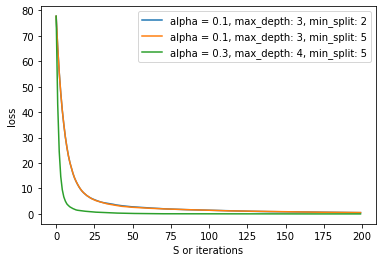

In [6]:

# Regression

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

reg_model1 = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 2, regression=True, tol=1e-4)

reg_model1.fit(X_train, y_train)
reg_yhat1 = reg_model1.predict(X_test)


print("MSE: ", mean_squared_error(y_test, reg_yhat1))



reg_model2 = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 5, regression=True, tol=1e-4)

reg_model2.fit(X_train, y_train)
reg_yhat2 = reg_model2.predict(X_test)


print("MSE: ", mean_squared_error(y_test, reg_yhat2))



reg_model3 = GradientBoosting(S=200, learning_rate=0.3, max_depth = 4, 
                 min_samples_split = 5, regression=True, tol=1e-4)

reg_model3.fit(X_train, y_train)
reg_yhat3 = reg_model3.predict(X_test)


print("MSE: ", mean_squared_error(y_test, reg_yhat3))


reg_model1.plot()
reg_model2.plot()
reg_model3.plot()

## Gradient Boosting on Binary Classification on breast_cancer

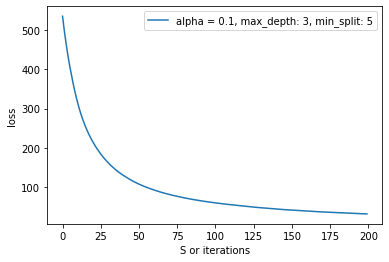

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))
for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

bi_model1 = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 5, regression=False)
bi_model1.fit(X_train, y_train_encoded)
bi_model1_yhat = bi_model1.predict(X_test)



bi_model1.plot()


0.9590643274853801


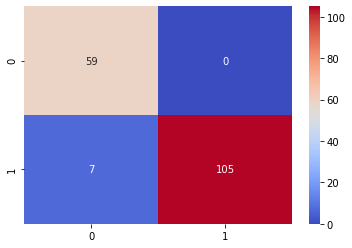

In [8]:
sns.heatmap(confusion_matrix(y_true = y_test , y_pred =bi_model1_yhat),
            annot= True, cmap = 'coolwarm', fmt= '.0f' )


print(accuracy_score(y_true = y_test , y_pred =bi_model1_yhat))

## Gradient Boosting on Multi-Class Classification on Iris Data

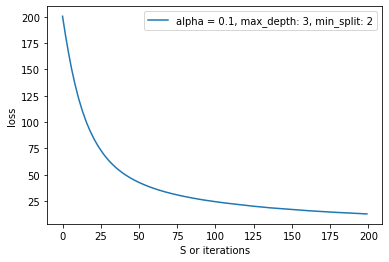

In [9]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
y_train_encoded = np.zeros((y_train.shape[0], len(set(y))))
for each_class in range(len(set(y))):
    cond = y_train==each_class
    y_train_encoded[np.where(cond), each_class] = 1

multi_model1 = GradientBoosting(S=200, learning_rate=0.1, max_depth = 3, 
                 min_samples_split = 2, regression=False)
multi_model1.fit(X_train, y_train_encoded)
multi_model1_yhat = multi_model1.predict(X_test)


multi_model1.plot()

0.9777777777777777


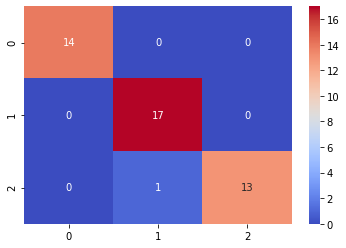

In [10]:
sns.heatmap(confusion_matrix(y_true = y_test , y_pred =multi_model1_yhat),
            annot= True, cmap = 'coolwarm', fmt= '.0f' )


print(accuracy_score(y_true = y_test , y_pred =multi_model1_yhat))

---
### Gradient Boosting Performance
- For every task :linear regression, binary classfication, multi-class classification, Gradient Boosting performs very well with the MSE less than 8 in regression and accuracy rate over 95% for classification
- Compared to original regression where we update theta over thousands of iterations, the boosting mehod can achieve very good results witin only a hundred iterations